In [2]:
import wandb
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from dice_ml.explainer_interfaces.explainer_base import UserConfigValidationException
from datetime import timedelta
import os
import re
import joblib
import sys
from aeon.utils.numba.stats import row_mean
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sympy import false

from scripts.SEP_CFE_functions import *
from slim_tsf.func.BaseSLIM import *
from slim_tsf.func._slim_TSF import *
from slim_tsf.func._sliding_intervals import *
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from slim_tsf.func._slim_TSF import SlimTimeSeriesForestClassifier

/Users/pranjal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/pranjal/Library/Python/3.9/lib/python/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/pranjal/Library/Python/3.9/lib/python/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' 

In [11]:
def build_mvts_dataset_3d(
    data_dir,
    label_file,
    selected_columns=None,
    timestamp_cols=("time_stamp", "time_tag", "timestamp"),
    start_min=300,
    end_min=660,
    fill_missing="pad"  # how to handle missing values: "pad" or "zero"
):
    """
    Build a 3D NumPy multivariate time series dataset (n_samples, n_channels, n_timepoints)
    suitable for SLIM-TSF or AEON models.

    Parameters
    ----------
    data_dir : str
        Folder containing all CSV time series files.
    label_file : str
        CSV with columns ['File', 'Label'] or ['filename', 'label'].
    selected_columns : list[str], optional
        Columns to keep (e.g. ['p3_flux_ic','p5_flux_ic','p7_flux_ic','short']).
    timestamp_cols : tuple[str]
        Possible names for timestamp column.
    start_min : int
        Start offset (in minutes) from first timestamp to begin trimming.
    end_min : int
        End offset (in minutes) from first timestamp to end trimming.
    fill_missing : str
        "pad" for forward-fill, "zero" to fill missing with zeros.

    Returns
    -------
    X : np.ndarray
        Array of shape (n_samples, n_channels, n_timepoints)
    y : np.ndarray
        Corresponding labels array of shape (n_samples,)
    """

    labels_df = pd.read_csv(label_file)
    # Standardize label columns
    possible_file_cols = ["File", "Filename", "filename"]
    possible_label_cols = ["Label", "label", "Class"]

    file_col = next((c for c in possible_file_cols if c in labels_df.columns), None)
    label_col = next((c for c in possible_label_cols if c in labels_df.columns), None)

    if file_col is None or label_col is None:
        raise ValueError("Label file must contain columns for filename and label.")

    data_list, label_list = [], []
    file_list = []

    for _, row in labels_df.iterrows():
        fname, label = row[file_col], row[label_col]
        fpath = os.path.join(data_dir, fname)
        if not os.path.exists(fpath):
            print(f"Missing file {fname}, skipping...")
            continue

        df = pd.read_csv(fpath)

        # --- Identify timestamp column ---
        ts_col = next((c for c in timestamp_cols if c in df.columns), None)
        if ts_col is None:
            print(f"No timestamp column found in {fname}, skipping...")
            continue

        # Parse timestamps and trim window
        df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
        start_time = df[ts_col].iloc[0] + timedelta(minutes=start_min)
        end_time = df[ts_col].iloc[0] + timedelta(minutes=end_min)
        df = df[(df[ts_col] >= start_time) & (df[ts_col] < end_time)].copy()

        if df.empty:
            print(f"Trimmed data empty for {fname}, skipping...")
            continue

        # Drop timestamp column
        df = df.drop(columns=[ts_col])

        # Keep only selected columns
        if selected_columns is not None:
            available_cols = [c for c in selected_columns if c in df.columns]
            df = df[available_cols]

        # Handle missing values
        if fill_missing == "pad":
            df = df.fillna(method="ffill").fillna(method="bfill")
        elif fill_missing == "zero":
            df = df.fillna(0)

        # Convert to NumPy array and transpose -> (channels, timepoints)
        arr = df.to_numpy().T
        data_list.append(arr)
        label_list.append(label)
        file_list.append(fname)


    # --- Ensure consistent sequence lengths ---
    min_len = min(a.shape[1] for a in data_list)
    X = np.stack([a[:, :min_len] for a in data_list])
    y = np.array(label_list)
    file_list = np.array(file_list)


    print(f"Loaded {len(X)} samples | shape = {X.shape} (n_samples, n_channels, n_timepoints)")
    return X, y , file_list


# ==== Example Usage ====
DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/data"
LABEL_FILE = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/SEP_class_labels.csv"

cols_to_use = ["p3_flux_ic", "p5_flux_ic", "p7_flux_ic", "long"]

X, y, file_list = build_mvts_dataset_3d(DATA_DIR, LABEL_FILE, selected_columns=cols_to_use)
print("Label distribution:\n", pd.Series(y).value_counts())



Missing file 1991-06-18_23-16.csv, skipping...


/var/folders/f7/zbff57wd2h14dcx8bnpxwkk80000gn/T/ipykernel_5001/1805332835.py:69: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")


Loaded 2892 samples | shape = (2892, 4, 360) (n_samples, n_channels, n_timepoints)
Label distribution:
 0    2648
1     244
Name: count, dtype: int64


In [12]:
#save data to file
np.savez_compressed("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/sep_slim_tsf_input_dataset.npz", X=X, y=y)
np.savez_compressed("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/sep_slim_tsf_input_combined_with_filelist.npz", X=X, y=y, file_list=file_list)#%%
# #load data from file
# data = np.load("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/sep_slim_tsf_input_dataset.npz")
# X = data['X']
# y = data['y']
# file_list = np.load("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/sep_slim_tsf_input_combined_with_filelist.npz")['file_list']

In [3]:
print(f"Dataset built: {X.shape[0]} samples, {X.shape[1]} channels")
print("Example row structure:\n", X[0])

Dataset built: 2892 samples, 4 channels
Example row structure:
 [[1.77200000e-01 1.60000000e-01 1.48000000e-01 ... 1.51800000e-01
  1.48600000e-01 1.45400000e-01]
 [9.80600000e-02 1.05000000e-01 9.23200000e-02 ... 9.34200000e-02
  9.02400000e-02 8.70600000e-02]
 [7.33000000e-02 8.02000000e-02 6.75600000e-02 ... 6.90800000e-02
  6.58600000e-02 6.26400000e-02]
 [3.17142857e-07 3.17142857e-07 3.15714286e-07 ... 2.37142857e-07
  2.28571429e-07 2.11428571e-07]]


In [24]:
temp_x, test_x, temp_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(temp_x, temp_y, test_size=0.3, stratify=temp_y, random_state=42)

print(f"Train size: {train_x.shape[0]}, Val size: {val_x.shape[0]}, Test size: {test_x.shape[0]}")

Train size: 1416, Val size: 608, Test size: 868


In [25]:
clf = SlimTimeSeriesForestClassifier(sec_trans=False)
clf.fit(train_x, train_y)

SlimTimeSeriesForestClassifier(sec_trans=False)

In [26]:
overall_results = []
y_pred = clf.predict(train_x)
overall_results.append(('training set',accuracy_score(train_y, y_pred), TSS(train_y, y_pred), HSS(train_y, y_pred)))
val_y_pred = clf.predict(val_x)
overall_results.append(('validation set',accuracy_score(val_y, val_y_pred), TSS(val_y, val_y_pred), HSS(val_y, val_y_pred)))
test_y_pred = clf.predict(test_x)
overall_results.append(('testing set',accuracy_score(test_y, test_y_pred), TSS(test_y, test_y_pred), HSS(test_y, test_y_pred)))
print(pd.DataFrame(overall_results, columns=["Dataset", "accuracy", "TSS", "HSS"]))

          Dataset  accuracy       TSS       HSS
0    training set  0.906780  0.739352  0.551641
1  validation set  0.899671  0.694547  0.515494
2     testing set  0.905530  0.697803  0.532260


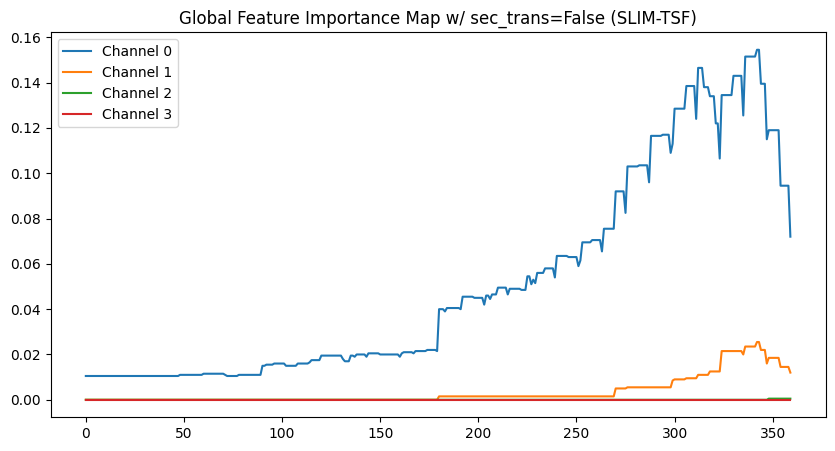

In [27]:
fmap = clf._feature_maps(train_x, train_y)
plt.figure(figsize=(10,5))
for ch, importance in fmap.items():
    plt.plot(list(importance.keys()), list(importance.values()), label=f'Channel {ch}')
plt.legend()
plt.title("Global Feature Importance Map w/ sec_trans=False (SLIM-TSF)")
plt.show()


In [58]:
clf = SlimTimeSeriesForestClassifier(
    sec_trans=False,
    bootstrap=True,
    bootstrap_run=10,
    top_rank=20,
    n_estimators=300,
    max_dep=5,
    random_state=42,
    windows=[180, 120, 90, 60, 45, 30, 15, 6],  # smaller windows than full length
    windows_steps_ratio=0.25,                   # 25% overlap
    features=[row_mean]
)


clf.fit(train_x, train_y)


SlimTimeSeriesForestClassifier(bootstrap=True, max_dep=5, n_estimators=300,
                               random_state=42, sec_trans=False,
                               windows=[180, 120, 90, 60, 45, 30, 15, 6],
                               windows_steps_ratio=0.25)

In [59]:
Xt = clf.tnf._fit_transform(train_x, train_y)
importances = clf.clf.feature_importances_
intervals = clf.tnf.intervals_

# 2️⃣ Sanity check
print(f"Extracted {len(importances)} features total across all windows/channels.")


Extracted 5 features total across all windows/channels.


In [60]:
Xt.shape[1]

4572

In [61]:
importances

array([0.06788027, 0.0849404 , 0.21874088, 0.27853667, 0.34990178])

In [62]:
clf2 = SlimTimeSeriesForestClassifier(
    sec_trans=False,
    bootstrap=False,
    bootstrap_run=10,
    top_rank=20,
    n_estimators=300,
    max_dep=5,
    random_state=42,
    windows=[180, 120, 90, 60, 45, 30, 15, 6],  # smaller windows than full length
    windows_steps_ratio=0.25,                   # 25% overlap
    features=[row_mean]
)

clf2.fit(train_x, train_y)


SlimTimeSeriesForestClassifier(max_dep=5, n_estimators=300, random_state=42,
                               sec_trans=False,
                               windows=[180, 120, 90, 60, 45, 30, 15, 6],
                               windows_steps_ratio=0.25)

In [66]:
Xt = clf2.tnf._fit_transform(train_x, train_y)
importances = clf2.clf.feature_importances_
intervals = clf2.tnf.intervals_

# 2️⃣ Sanity check
print(f"Extracted {len(importances)} features total across all windows/channels.")
print("Features shape:", Xt.shape)

Extracted 4572 features total across all windows/channels.
Features shape: (1416, 4572)


In [71]:
# Channel labels (in the same order as your dataset)
channel_labels = ["P3", "P5", "P7", "Long"]
# Filter for row_mean features only
ranked = sorted(
    [
        (imp, interval)
        for imp, interval in zip(importances, intervals)
        # if callable(interval[3]) and getattr(interval[3], "__name__", "") == "row_mean"
    ],
    key=lambda x: x[0],
    reverse=True
)

top_k = ranked[:20]
print(f"Extracted {len(importances)} features total, showing top {len(top_k)}.")
print("\nTop-20 Global Interval Features (row_mean, SLIM-TSF)")
print("=" * 80)
for rank, (imp, (start, end, ch, func, *_)) in enumerate(top_k, 1):
    ch_label = channel_labels[ch] if ch < len(channel_labels) else f"Ch{ch}"
    print(f"{rank:>2}. {ch_label:<5} | [{start:>3}:{end:<3}] | Importance = {imp:.5f}")



Extracted 4572 features total, showing top 20.

Top-20 Global Interval Features (row_mean, SLIM-TSF)
 1. P3    | [240:360] | Importance = 0.01674
 2. P3    | [332:347] | Importance = 0.01666
 3. P3    | [312:357] | Importance = 0.01634
 4. P3    | [285:345] | Importance = 0.01537
 5. P3    | [352:358] | Importance = 0.01450
 6. P3    | [354:360] | Importance = 0.01224
 7. P3    | [324:339] | Importance = 0.01173
 8. P3    | [342:348] | Importance = 0.01170
 9. P3    | [348:354] | Importance = 0.01033
10. P3    | [180:360] | Importance = 0.01024
11. P3    | [340:346] | Importance = 0.00987
12. P3    | [240:360] | Importance = 0.00985
13. P3    | [336:351] | Importance = 0.00944
14. P3    | [350:356] | Importance = 0.00925
15. P3    | [332:338] | Importance = 0.00885
16. P3    | [300:345] | Importance = 0.00877
17. P3    | [300:345] | Importance = 0.00860
18. P3    | [328:358] | Importance = 0.00854
19. P3    | [338:344] | Importance = 0.00837
20. P3    | [285:345] | Importance = 0.00787

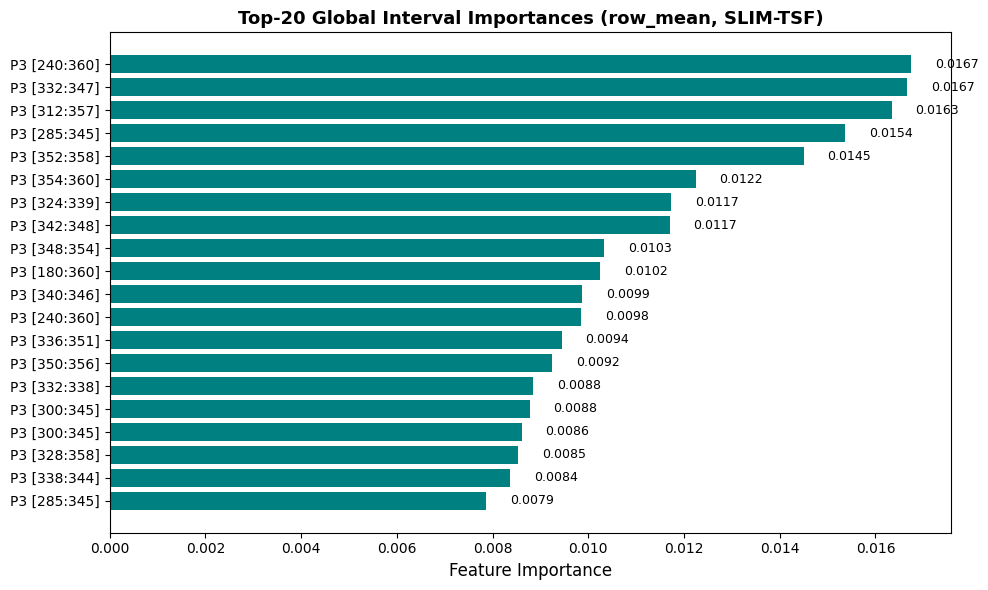

In [72]:
# Prepare data for plotting
labels = [f"{channel_labels[ch]} [{start}:{end}]" for _, (start, end, ch, _, *_) in top_k]
values = [imp for imp, _ in top_k]

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(top_k)), values, color="teal")
plt.yticks(range(len(top_k)), labels, fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance", fontsize=12)
plt.title("Top-20 Global Interval Importances (row_mean, SLIM-TSF)", fontsize=13, weight="bold")

for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.0005, bar.get_y() + bar.get_height()/2,
             f"{values[i]:.4f}", va='center', fontsize=9)
plt.tight_layout()
plt.show()
